In [2]:
import sys
import sklearn
import numpy as np
import math
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import sklearn.cluster
import random as rd
import time
from scipy.stats import norm
from scipy.spatial import Voronoi, voronoi_plot_2d

# Fixer la graine.
seed = 5

In [3]:
import random as rd
import time


# Fonction qui genere un echantillon de taille n issu d'un melange gaussien.
def gaussian_mixture(n,probs,means,covs):
    """
    Genere un echantillon a partir d'un melange de gaussiennes.
    
    Args:
        n (int): Nombre total d'observations a generer.
        probs (list): Liste des probabilites de chaque composante de la distribution.
        means (list): Liste des moyennes de chaque composante de la distribution.
        covs (list): Liste des matrices de covariance de chaque composante de la distribution.

    Returns:
        tuple : Un tuple contenant :
            - np.array : Un tableau de taille (n, d), ou d est la dimension de l'espace des observations. Chaque ligne est une observation generee a partir du melange de gaussiennes.
            - list : Une liste contenant le nombre d'observations generees pour chaque composante de la distribution.
    
    Raises:
        ValueError: Si les listes probs, means et covs n'ont pas la meme longueur ou si elles sont vides.
    
    Exemple:
        >>> # Generer un echantillon de 1000 observations à partir d'un melange de deux gaussiennes
        >>> probs = [0.3, 0.7]
        >>> means = [np.array([1, 1]), np.array([-1, -1])]
        >>> covs = [np.array([[1, 0], [0, 1]]), np.array([[2, 0], [0, 2]])]
        >>> X, sizes = gaussian_mixture(1000, probs, means, covs)
    """
    # Initialisation du generateur de nombres aleatoires
    random_gen=np.random.default_rng(seed) 
    # Generation du nombre d'observations pour chaque composante de la distribution
    nb=random_gen.multinomial(n,probs)
    sizes = []
    X=[]
    d = means[0].shape[0]

    # Boucle sur chaque composante de la distribution
    for i in range(len(probs)):
        if (d==1):
          # Cas unidimensionnel : generation de nombres aleatoires a partir d'une loi normale unidimensionnelle
          u=random_gen.normal(means[i],covs[i],size=nb[i])
        else:
          # Cas multidimensionnel : generation de nombres aleatoires a partir d'une loi normale multidimensionnelle
          u=random_gen.multivariate_normal(means[i],covs[i],size=nb[i])
        X.append(u)
        sizes.append(nb[i])
    return (np.concatenate(X),sizes)


def circle_random_points(n,r):
    
    """
    Genere n points aleatoires uniformement repartis sur un cercle de rayon r centre en (0, 0).

    """
    # Cree un generateur de nombres aleatoires
    random_gen=np.random.default_rng(seed)

    v=2*np.pi*random_gen.uniform(0,1,size=n)
    x=r*np.cos(v)
    y=r*np.sin(v)
    points=np.transpose([x,y])
    return points


def scatter_points(points):
    """
    Affiche un nuage de points a partir d'une liste de points.
    """
    (x,y)=np.array(points).transpose()
    plt.scatter(x,y)

def ax_scatter_points(points,ax):
    """
    Affiche un nuage de points sur un axe spacifie a partir d'une liste de points.
    """
    (x,y)=np.array(points).transpose()
    ax.scatter(x,y)


def arg_closest(point,centroids):
    """
    Renvoie l'indice (ou les indices si plusieurs sont a egale distance) 
    du centroide le plus proche d'un point donne.
    
    Args:
    - point (array): un point dans l'espace.
    - centroids (list): liste des centroides.
    
    Returns:
    - arg (list): indice (ou indices) du centroide le plus proche.
    """
    arg=[0]
    for i in range(1,len(centroids)):
        d1=np.linalg.norm(point-centroids[i])
        d2=np.linalg.norm(point-centroids[arg[0]])
        if d1==d2:
            arg.append(i)

        if d1<d2:
            arg=[i]
    if len(arg)!=1:
        print("nombre de centroides a distance egale:",len(arg))
    return arg

def find_centroids(cluster):
    """
    Calcule le centroide d'un cluster.
    
    Args:
    - cluster (list): liste des points du cluster.
    
    Returns:
    - centroids (list): liste des centroides.
    """
    centroids=[]
    for i in cluster:
            centroids.append(np.mean(i,axis=0))
    return centroids


def find_centroids_replaceifempty(cluster,centroids):
    """
    Calcule le centroide d'un cluster et remplace les centroides vides par les centroides precedents.
    
    Args:
    - cluster (list): liste des points du cluster.
    - centroids (list): liste des centroides.
    
    Returns:
    - new_centroids (list): liste des nouveaux centroides.
    """
    new_centroids=[]
    for i in range(len(cluster)):
            if len(cluster[i])!=0:
                new_centroids.append(np.mean(cluster[i],axis=0))
            else:
                new_centroids.append(centroids[i])
    return new_centroids

def kmeans_step (points,cluster,centroids):
    """
    Etape du k-means: attribue a chaque point le cluster dont le centroide est le plus proche.
    
    Args:
    - points (array): tableau contenant les points.
    - cluster (list): liste des clusters.
    - centroids (list): liste des centroides.
    
    Returns:
    - new_cluster (list): nouvelle liste des clusters.
    """
    new_cluster=[]
    for i in range(len(centroids)):new_cluster.append([])
    for i in points:
        arg=arg_closest(i,centroids)
        arg_default=arg[0]
        new_cluster[arg_default].append(i)
    return new_cluster


#K-Means
def kmeans(points,cluster,calculate_var=True):
    """
    Implemente l'algorithme K-Means pour une liste de points et de clusters.
    
    Args:
    - points (array): tableau contenant les points.
    - cluster (list): liste des clusters initiaux.
    - calculate_var (bool): si True, calcule la variance a chaque etape de l'algorithme.
    
    Returns:
    - cluster (list): liste des clusters finale.
    - var_tab (array): tableau de la variance a chaque etape de l'algo (ou tableau vide si calculate_var=False).
    """
    
    # Calcul des centroides initiaux
    centroids=find_centroids(cluster)
    # Initialisation du tableau de variance si demande
    if calculate_var: 
      var_tab = np.array([variance(points,cluster,centroids)])
    else:
      var_tab = np.array([])

    # Etape initiale
    new_cluster=kmeans_step(points,cluster,centroids)
    new_centroids=find_centroids_replaceifempty(new_cluster,centroids)
    # Boucle principale
    while not(np.array_equal(centroids,new_centroids)):
        # Mise a jour des clusters et des centroides
        (cluster,centroids)=(new_cluster,new_centroids)
        new_cluster=kmeans_step(points,cluster,centroids)
        new_centroids=find_centroids_replaceifempty(new_cluster,centroids)
        # Calcul de la variance si demande
        if calculate_var:
          var_tab = np.append(var_tab,variance(points,new_cluster,new_centroids))
    
    return cluster,var_tab


def random_init_same_size(k,points):
    """
    Repartit de maniere aleatoire les points en k clusters de meme taille.

    Args:
    - k (int): nombre de clusters
    - points (array-like): liste ou tableau numpy des points a repartir

    Returns:
    - new_cluster (list): liste de k clusters ou chaque cluster est une liste de points
    """
    random_gen=np.random.default_rng(seed)
    a=np.array(points)
    random_gen.shuffle(a)
    new_cluster=[]
    for i in range(k): new_cluster.append([])
    for i in range(len(a)):new_cluster[i%k].append(a[i])
    return new_cluster


def variance(points,clusters,centroids):
    """
    Calcule la variance intra-classe a partir de l'ensemble des points, des clusters, et des centroides.

    Args:
    - points (array-like): liste ou tableau numpy des points a repartir
    - clusters (list): liste de k clusters ou chaque cluster est une liste de points
    - centroids (list): liste de k centroides

    Returns:
    - var (float): variance intra-classe
    """
    n = len(points)
    K = len(clusters)
    dist = 0
    for k in range(K):
      for i in range(n):
        for j in clusters[k]:
          if ((np.array(points[i]) == j).all()): # si le point appartient au cluster k
            dist += np.linalg.norm(points[i]-centroids[k],ord=2)**2
    return (1/n)*dist # variance intra-classe



random_gen=np.random.default_rng(seed) #definit le generateur de nombes aleatoires

In [4]:
help(gaussian_mixture)

Help on function gaussian_mixture in module __main__:

gaussian_mixture(n, probs, means, covs)
    Genere un echantillon a partir d'un melange de gaussiennes.
    
    Args:
        n (int): Nombre total d'observations a generer.
        probs (list): Liste des probabilites de chaque composante de la distribution.
        means (list): Liste des moyennes de chaque composante de la distribution.
        covs (list): Liste des matrices de covariance de chaque composante de la distribution.
    
    Returns:
        tuple : Un tuple contenant :
            - np.array : Un tableau de taille (n, d), ou d est la dimension de l'espace des observations. Chaque ligne est une observation generee a partir du melange de gaussiennes.
            - list : Une liste contenant le nombre d'observations generees pour chaque composante de la distribution.
    
    Raises:
        ValueError: Si les listes probs, means et covs n'ont pas la meme longueur ou si elles sont vides.
    
    Exemple:
        >>

Exemple de Gaussian Mixture

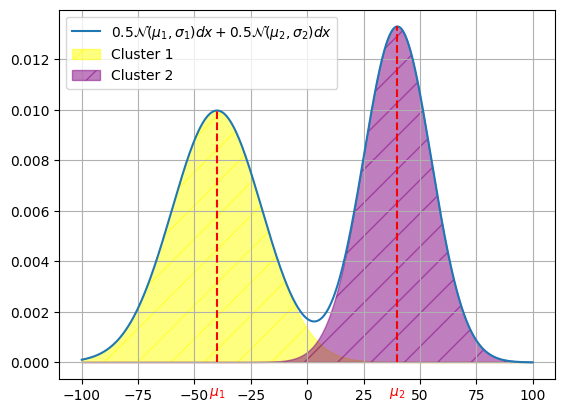

In [5]:
# Fonction qui renvoie la valeur de la densite au point x d'un melange gaussien.
def dmg(x,means,vars,probs):
  z = np.column_stack((means, vars, probs))
  return np.sum(np.array([p*norm.pdf(x,loc=mean,scale=var) for [mean,var,p] in z]))

# Graphe de la densite d'un melange gaussien
means = np.array([-40,40])
vars = np.array([20,15])
probs = np.array([1/2,1/2])
xx = np.linspace(-100,100,1000)
yy = [dmg(x,means,vars,probs) for x in xx]
plt.grid()
plt.plot(xx,yy)
plt.fill_between(xx,0.5*norm.pdf(xx,loc=-40,scale=20),alpha=0.5,color="yellow",hatch='/')
plt.fill_between(xx,0.5*norm.pdf(xx,loc=40,scale=15),alpha=0.5,color="purple",hatch='/')
plt.vlines([-40,40], ymin=0, ymax=[dmg(-40,means,vars,probs),dmg(40,means,vars,probs)], colors='r', linestyles='dashed')
plt.text(-40, -0.0015,  r'$\mu_{1}$', c="red",ha='center', va='bottom')
plt.text(40, -0.0015,  r'$\mu_{2}$', c="red",ha='center', va='bottom')
plt.legend(["$0.5\mathcal{N}(\mu_1,\sigma_1)dx+0.5\mathcal{N}(\mu_2,\sigma_2)dx$","Cluster 1","Cluster 2"])
plt.savefig('/content/melange_gaussien_1d.png')


Premier K-Means

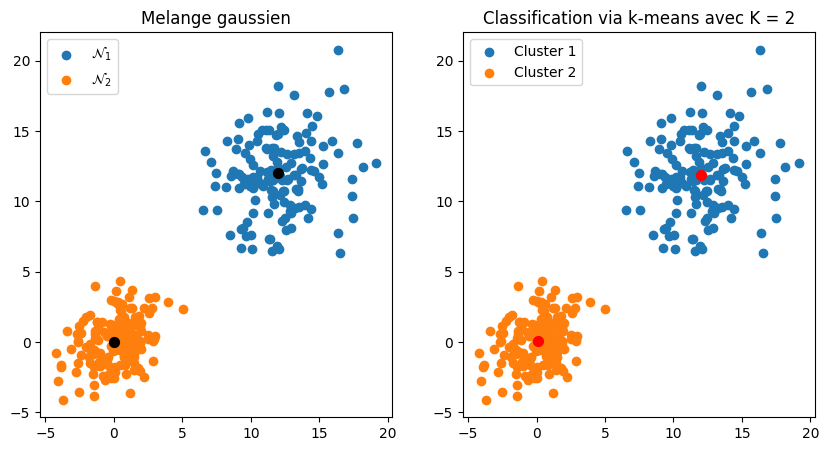

In [6]:
# Definition du melange gaussien
means = np.array([[0,0],[12,12]])
covs = [np.array([[3,1],[1,3]]),np.array([[7,1],[1,7]])]
m,sizes = gaussian_mixture(300,[0.5,0.5],means,covs)
l = sizes[0]

# Application du k-means pour k=2
k = 2
init=random_init_same_size(k,m)
km,_ = kmeans(m,init,calculate_var=False)

# Representation graphique des clusters et des centroides
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].scatter([a[0] for a in m[l:]], [a[1] for a in m[l:]])
axs[0].scatter([a[0] for a in m[:l]], [a[1] for a in m[:l]])
cd = find_centroids(km)
axs[0].scatter(0,0,c='black',s=50)
axs[0].scatter(12,12,c='black',s=50)
axs[0].legend(["$\mathcal{N}_1$","$\mathcal{N}_2$"])
axs[0].set_title("Melange gaussien")

cd = find_centroids(km)
for i in km:
    scatter_points(i)
axs[1].scatter(cd[0][0],cd[0][1],c='red',s=50)
axs[1].scatter(cd[1][0],cd[1][1],c='red',s=50)
axs[1].legend(["Cluster 1","Cluster 2"])
axs[1].set_title("Classification via k-means avec K = 2")
plt.savefig('/content/ex1.png')
plt.show()

Test de la convergence des centroids

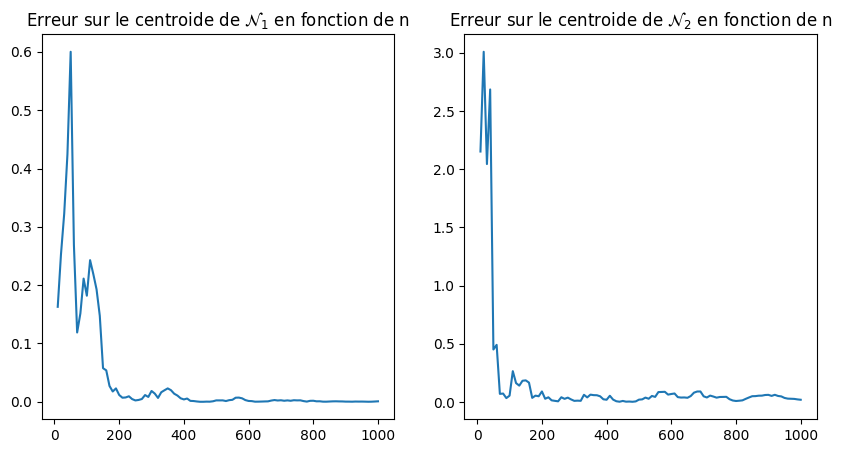

In [7]:
# Definition du melange gaussien
means = np.array([[0,0],[12,12]])
covs = [np.array([[3,1],[1,3]]),np.array([[7,1],[1,7]])]

# Fixer le nombre de clusters
k = 2

L = np.linspace(10,1000,100) # Liste des initialisations
dists1 = [] # Liste des erreurs sur le premier centroide
dists2 = [] # Liste des erreurs sur le second centroide

# Completion des tableaux des erreurs aux centroides en appliquant kmeans sur differentes valeurs de n
for n in L:
  m,_ = gaussian_mixture(n,[0.5,0.5],means,covs)
  init=random_init_same_size(k,m)
  km,_ = kmeans(m,init,calculate_var=False)
  cd = find_centroids(km)
  #print(cd)
  dists1.append(min(np.linalg.norm(means[0]-cd[0])**2,np.linalg.norm(means[0]-cd[1])**2))
  dists2.append(min(np.linalg.norm(means[1]-cd[0])**2,np.linalg.norm(means[1]-cd[1])**2))

# Representation graphique des deux erreurs
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(L,dists1)
axs[0].set_title("Erreur sur le centroide de $\mathcal{N}_1$ en fonction de n")
axs[1].plot(L,dists2)
axs[1].set_title("Erreur sur le centroide de $\mathcal{N}_2$ en fonction de n")
plt.savefig('/content/erreur_centroids.png')
plt.show()



Centroids:  [2.57109249 3.17025919] [ 0.07450893 -0.41792057]


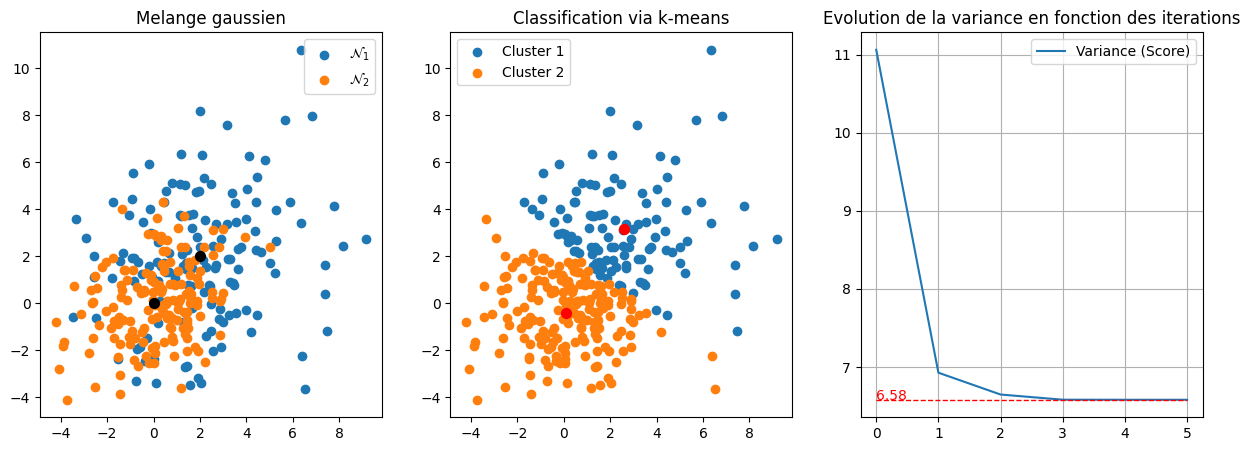

[array([2.57109249, 3.17025919]), array([ 0.07450893, -0.41792057])]


In [8]:
# Definition du melange gaussien
means = np.array([[0,0],[2,2]])
covs = [np.array([[3,1],[1,3]]),np.array([[7,1],[1,7]])]
m,sizes = gaussian_mixture(300,[0.5,0.5],means,covs)
l = sizes[0]

# Application du k-means pour k=2
k = 2
init=random_init_same_size(k,m)
km,tab_var = kmeans(m,init)

# Representation graphique
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].scatter([a[0] for a in m[l:]], [a[1] for a in m[l:]])
axs[0].scatter([a[0] for a in m[:l]], [a[1] for a in m[:l]])
cd = find_centroids(km)
axs[0].scatter(0,0,c='black',s=50)
axs[0].scatter(2,2,c='black',s=50)
axs[0].legend(["$\mathcal{N}_1$","$\mathcal{N}_2$"])
axs[0].set_title("Melange gaussien")
cd = find_centroids(km)
for i in km:
    (x,y)=np.array(i).transpose()
    axs[1].scatter(x,y)
axs[1].scatter(cd[0][0],cd[0][1],c='red',s=50)
axs[1].scatter(cd[1][0],cd[1][1],c='red',s=50)
axs[1].legend(["Cluster 1","Cluster 2"])
axs[1].set_title("Classification via k-means")
print("Centroids: ", cd[0],cd[1])

v  = variance(m,km,cd)
axs[2].plot(tab_var)
axs[2].grid()
axs[2].hlines(y=v, xmin=0, xmax=len(tab_var)-1, colors='r', linestyles='dashed',linewidth=1)
axs[2].annotate('{:.2f}'.format(v), xy=(0, v), xytext=(0, v), fontsize=10,color="red")
axs[2].legend(["Variance (Score)"])
axs[2].set_title("Evolution de la variance en fonction des iterations")
axs[2].set_xticks(np.arange(0, len(tab_var), 1))
plt.savefig('/content/ex2.png')
plt.show()
#print("variances:", tab_var)
#print(v)
print(cd)

Centroids:  [8.10485873 8.28354534] [1.4017334  1.13676944]


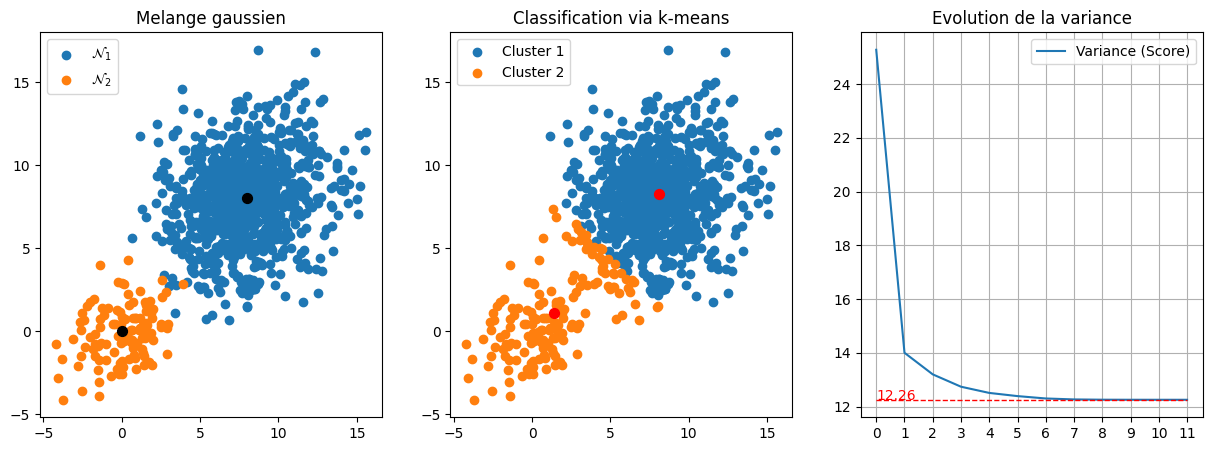

'\nprint("variances:", tab_var)\nprint("Variance finale", v)\n#Avec KMeans de scikit learn\nkms = sklearn.cluster.KMeans(n_clusters=2).fit(m)\nprint("Variance finale avec scikit_learn:", kms.inertia_/1000)\n'

In [9]:
# Definition du melange gaussien
means = np.array([[0,0],[8,8]])
covs = [np.array([[3,1],[1,3]]),np.array([[7,1],[1,7]])]
m,sizes = gaussian_mixture(1000,[0.1,0.9],means,covs)
l = sizes[0]

# Application de k-means pour k=2
k = 2
init=random_init_same_size(k,m)
km,tab_var = kmeans(m,init)

# Representation graphique
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].scatter([a[0] for a in m[l:]], [a[1] for a in m[l:]])
axs[0].scatter([a[0] for a in m[:l]], [a[1] for a in m[:l]])
cd = find_centroids(km)
axs[0].scatter(0,0,c='black',s=50)
axs[0].scatter(8,8,c='black',s=50)
axs[0].legend(["$\mathcal{N}_1$","$\mathcal{N}_2$"])
axs[0].set_title("Melange gaussien")
cd = find_centroids(km)
for i in km:
    (x,y)=np.array(i).transpose()
    axs[1].scatter(x,y)
axs[1].scatter(cd[0][0],cd[0][1],c='red',s=50)
axs[1].scatter(cd[1][0],cd[1][1],c='red',s=50)
axs[1].legend(["Cluster 1","Cluster 2"])
axs[1].set_title("Classification via k-means")
print("Centroids: ", cd[0],cd[1])

v  = variance(m,km,cd)
axs[2].plot(np.array(range(len(tab_var))),tab_var)
axs[2].set_xticks(np.arange(0, len(tab_var), 1))
axs[2].grid()
axs[2].hlines(y=v, xmin=0, xmax=len(tab_var)-1, colors='r', linestyles='dashed',linewidth=1)
axs[2].annotate('{:.2f}'.format(v), xy=(0, v), xytext=(0, v), fontsize=10,color="red")
axs[2].legend(["Variance (Score)"])
axs[2].set_title("Evolution de la variance")
plt.savefig('/content/ex3.png')
plt.show()

'''
print("variances:", tab_var)
print("Variance finale", v)
#Avec KMeans de scikit learn
kms = sklearn.cluster.KMeans(n_clusters=2).fit(m)
print("Variance finale avec scikit_learn:", kms.inertia_/1000)
'''

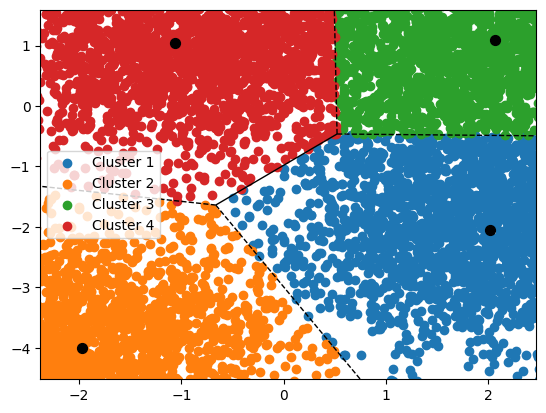

Probabilities: [0.2584, 0.2456, 0.246, 0.25]
Centroids: [array([ 2.01516369, -2.05730937]), array([-1.97535827, -4.01225507]), array([2.06333189, 1.08438386]), array([-1.06038243,  1.04388805])]


In [10]:
# Definir le melange gaussien
probs = [0.25, 0.25, 0.25, 0.25]
means = [np.array([-1, 1]), np.array([2, 1]), np.array([2, -2]), np.array([-2, -4])]
covs = [np.array([[1, 0], [0, 1]]), np.array([[1, 0], [0, 1]]), np.array([[1, 0], [0, 1]]), np.array([[1, 0], [0, 1]])]
n = 10000
m, sizes = gaussian_mixture(n, probs, means, covs)

# Application de k-means pour k=4
k = 4
init=random_init_same_size(k,m)
km,_ = kmeans(m,init,calculate_var=False)
cd = find_centroids(km)
#Representation graphique
for i in km:
    (x,y)=np.array(i).transpose()
    plt.scatter(x,y)
for i in range(k):
  plt.scatter(cd[i][0],cd[i][1],c='black',s=50)
plt.legend(["Cluster {}".format(i+1) for i in range(k)])
vor = Voronoi(cd)
voronoi_plot_2d(vor,show_vertices=False,show_points=False,ax=plt.gca())
plt.savefig('/content/voronoi_kmeans.png')
plt.show()
print("Probabilities:", [len(km[i])/n for i in range(k)])
print("Centroids:", cd)

Autres que mélanges gaussiens

[9.10515316 5.67993596 5.59895932 5.58540454 5.58540454]


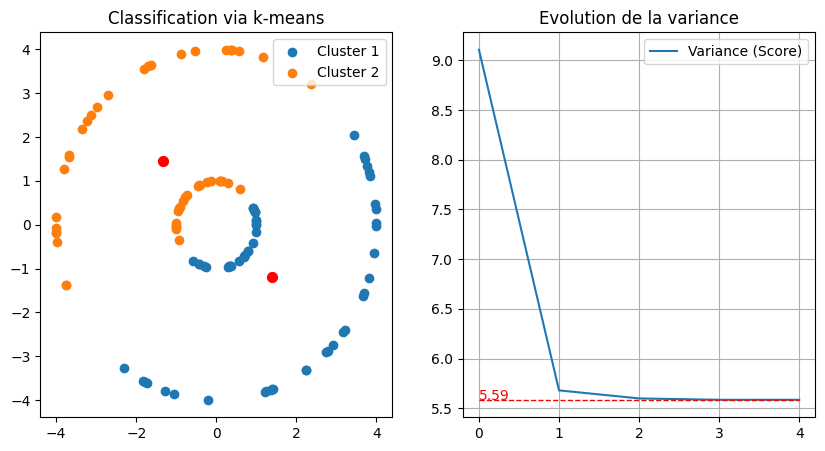

In [11]:
# Generation des données
c1=circle_random_points(50,1)
c2=circle_random_points(60,4)
c=np.concatenate((c1,c2),axis=0)

# Application de k-means
k=2
clusters=random_init_same_size(k,c)
km,tab_var = kmeans(c,clusters)
cd = find_centroids(km)

# Representation graphique
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

for i in km:
    ax_scatter_points(i,axs[0])
axs[0].legend(["Cluster 1","Cluster 2"])
axs[0].scatter(cd[0][0],cd[0][1],c='red',s=50)
axs[0].scatter(cd[1][0],cd[1][1],c='red',s=50)
axs[0].set_title("Classification via k-means")
v  = variance(c,km,cd)

axs[1].plot(tab_var)
axs[1].grid()
axs[1].hlines(y=v, xmin=0, xmax=len(tab_var)-1, colors='r', linestyles='dashed',linewidth=1)
axs[1].annotate('{:.2f}'.format(v), xy=(0, v), xytext=(0, v), fontsize=10,color="red")
axs[1].legend(["Variance (Score)"])
axs[1].set_title("Evolution de la variance")
axs[1].set_xticks(np.arange(0, len(tab_var), 1))
print(tab_var)
plt.savefig('/content/cex1.png')
plt.show()

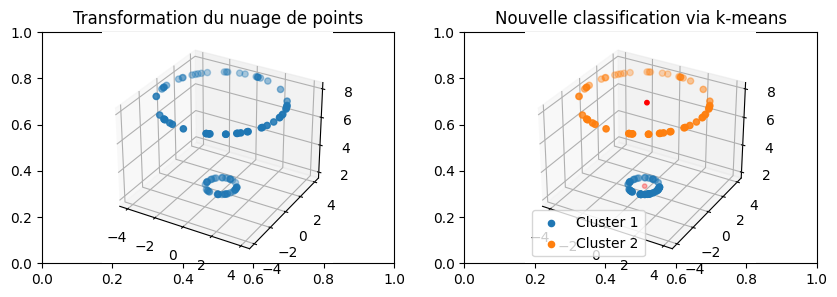

'\nv  = variance(new_c.transpose(),km,cd)\nprint(v)\n'

In [12]:
# Generation des 110 donnees
c1=circle_random_points(50,1)
c2=circle_random_points(60,4)
c=np.concatenate((c1,c2),axis=0)

# Fonction de Feature mapping
def phi(X):
  L = np.array([np.linalg.norm([x,y]) for [x,y] in X])
  return np.array([X[:,0],X[:,1],2*L])

# Application de k-means
k=2
new_c = phi(c)
clusters = random_init_same_size(k,new_c.transpose())
km,tab_var = kmeans(new_c.transpose(),clusters)
cd = find_centroids(km)

# Representation graphique
fig, axs = plt.subplots(1,2, figsize=(10, 3))

axs[0] = fig.add_subplot(121, projection='3d')
axs[0].scatter(new_c[0], new_c[1], new_c[2])
axs[0].set_title("Transformation du nuage de points")

axs[1] = fig.add_subplot(122, projection='3d')
axs[1].scatter([a[0] for a in km[0]], [a[1] for a in km[0]], [a[2] for a in km[0]])
axs[1].scatter([a[0] for a in km[1]], [a[1] for a in km[1]], [a[2] for a in km[1]])
axs[1].legend(["Cluster 1","Cluster 2"])
axs[1].scatter([a[0] for a in cd], [a[1] for a in cd],[a[2] for a in cd],c='red',s=10)
axs[1].set_title("Nouvelle classification via k-means")
# Afficher la figure
plt.savefig('/content/cex1transfo.png')
plt.show()

'''
v  = variance(new_c.transpose(),km,cd)
print(v)
'''


[1.00069766 0.39996957 0.39831172 0.39831172]


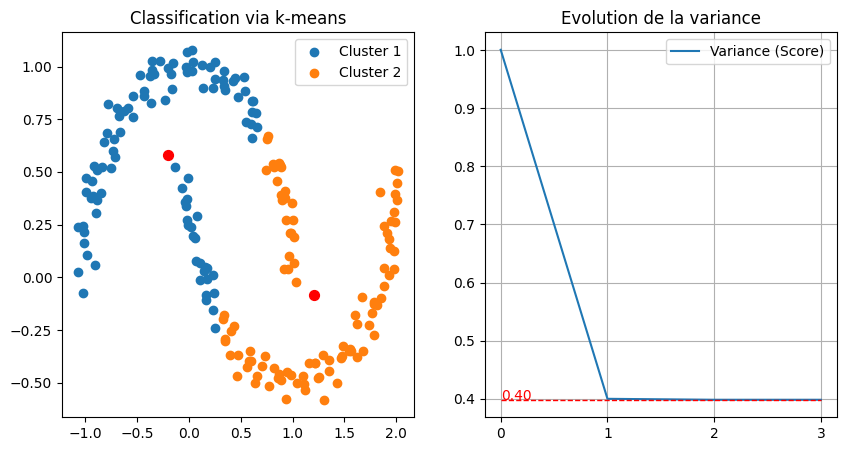

In [13]:
from sklearn.datasets import make_moons

# Generation de 200 donnees
c = make_moons(200, noise=.05, random_state=0)[0]
clusters=random_init_same_size(k,c)
k=2
km,tab_var = kmeans(c,clusters)
cd = find_centroids(km)

# Representation graphique
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

for i in km:
    ax_scatter_points(i,axs[0])
axs[0].legend(["Cluster 1","Cluster 2"])
axs[0].scatter(cd[0][0],cd[0][1],c='red',s=50)
axs[0].scatter(cd[1][0],cd[1][1],c='red',s=50)
axs[0].set_title("Classification via k-means")
v  = variance(c,km,cd)

axs[1].plot(tab_var)
axs[1].grid()
axs[1].hlines(y=v, xmin=0, xmax=len(tab_var)-1, colors='r', linestyles='dashed',linewidth=1)
axs[1].annotate('{:.2f}'.format(v), xy=(0, v), xytext=(0, v), fontsize=10,color="red")
axs[1].legend(["Variance (Score)"])
axs[1].set_title("Evolution de la variance")
axs[1].set_xticks(np.arange(0, len(tab_var), 1))
print(tab_var)
plt.savefig('/content/cex2.png')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


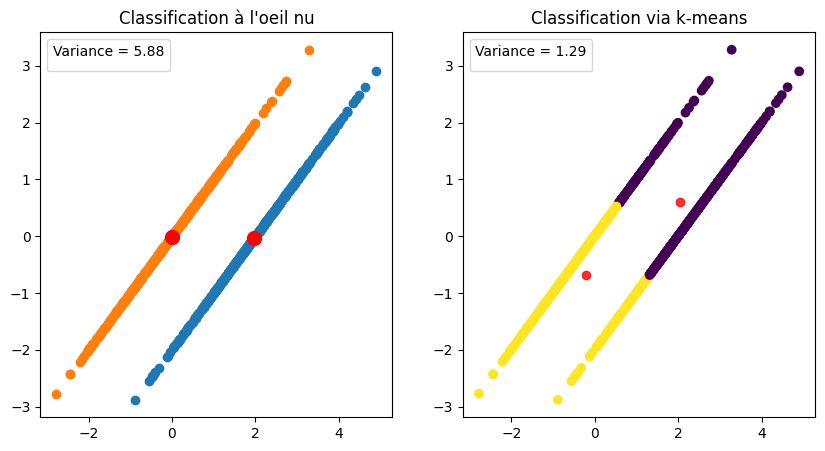

In [14]:
from matplotlib.patches import Rectangle

# Generation de donnees (mélange gaussien)
means = np.array([[0,0],[2,0]])
covs = [np.array([[1,1],[1,1]]),np.array([[1,1],[1,1]])]
m,sizes = gaussian_mixture(1000,[0.5,0.5],means,covs)
l = sizes[0]

# Application de k-means avec sklearn
k = 2
n = len(m)
km = sklearn.cluster.KMeans(n_clusters=k).fit(m)
kmeansLabels = km.predict(m)

# Definir la taille et la disposition des subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].scatter([a[0] for a in m[l:]], [a[1] for a in m[l:]])
axs[0].scatter([a[0] for a in m[:l]], [a[1] for a in m[:l]])
c = find_centroids([m[:l]]) + find_centroids([m[l:]])
axs[0].scatter([a[0] for a in c], [a[1] for a in c],c="red",s=100)
axs[0].set_title("Classification à l'oeil nu")
axs[0].legend(title='Variance = ' + str(round(variance(m,[m[l:],m[:l]],c),2)))

axs[1].scatter(m[:, 0], m[:, 1], c=kmeansLabels, cmap='viridis')
axs[1].legend(title='Variance = ' + str(round((km.inertia_)/n,2)))
clusterCenters = km.cluster_centers_
axs[1].scatter(clusterCenters[:, 0], clusterCenters[:, 1], c='red', alpha=0.8)
axs[1].set_title("Classification via k-means")

# Afficher les plots
plt.savefig('/content/cex3.png')
plt.show()

Sensibilité à l'initialisation

[array([0.10319484, 0.10424872, 0.01837743]), array([25.0803443 , 28.95054449, 28.00337289]), array([15.2659787 , 15.02275341, 15.10645056])]


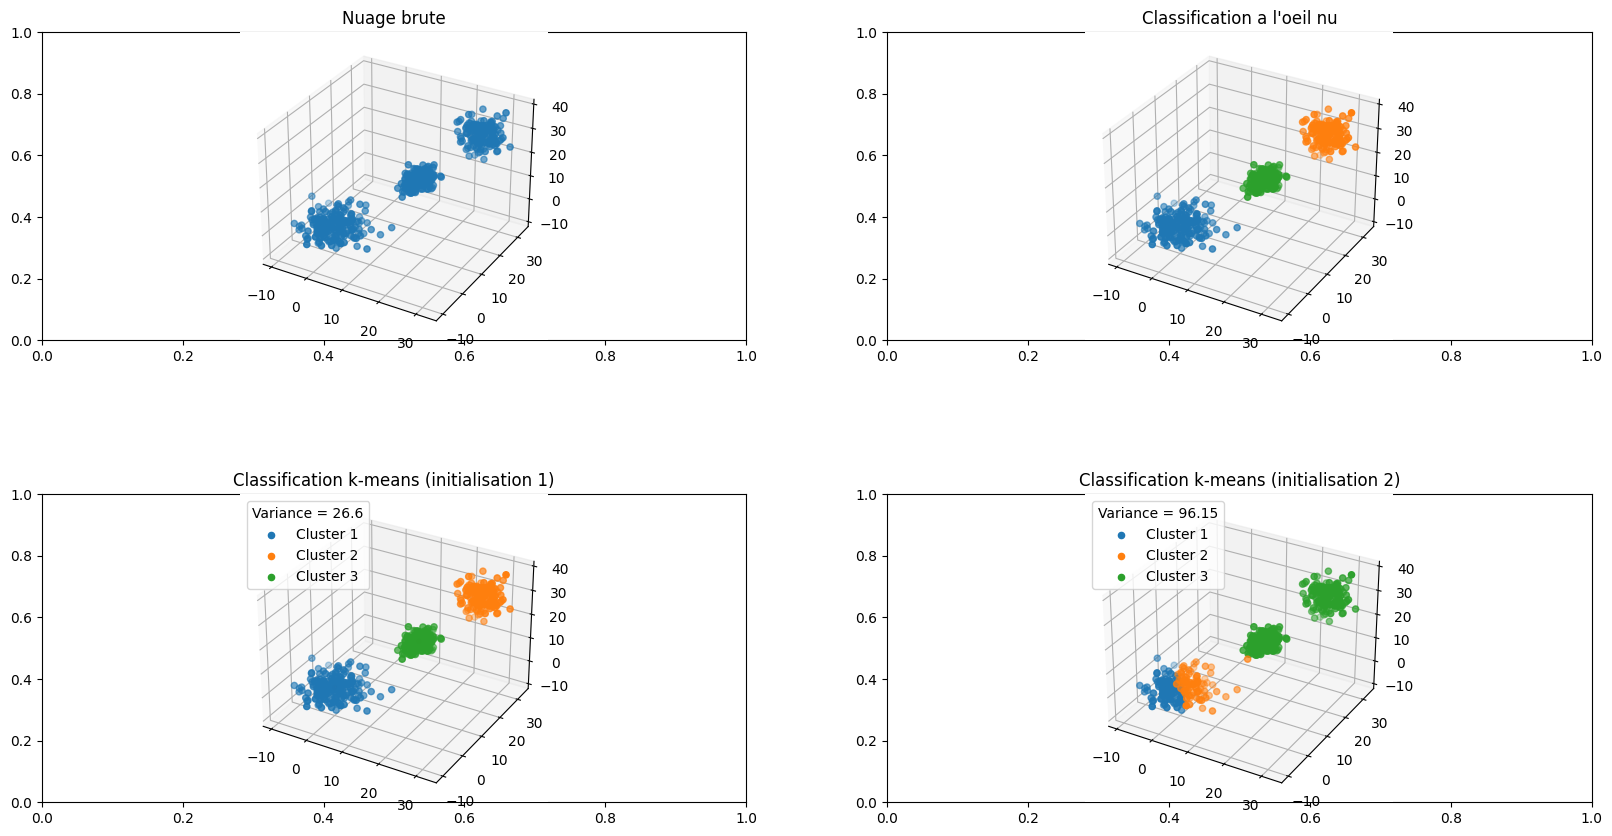

In [15]:
# Definition du melange gaussien
n = 500
means = np.array([[0,0,0],[25,29,28],[15,15,15]])
covs = [np.array([[15, 1, 1], [1, 15, 1], [1,1, 15]]),np.array([[7, 1, 1], [1, 3, 1], [1, 1, 12]]),np.array([[4, 1, 1], [1, 5, 1], [1, 1, 6]])]
m,sizes = gaussian_mixture(n,[1/3,1/3,1/3],means,covs)
l1 = sizes[0]
l2 = sizes[1]

# Application de k-means
k=3
init = random_init_same_size(k,m)
km,_ = kmeans(m,init)
cd = find_centroids(km)

# Representation graphique
fig, axs = plt.subplots(2,2, figsize=(20, 10))
plt.subplots_adjust(hspace=0.5)
axs[0,0] = fig.add_subplot(221, projection='3d')
axs[0,0].scatter([a[0] for a in m],[a[1] for a in m],[a[2] for a in m])
axs[0,0].set_title("Nuage brute")

axs[0,1] = fig.add_subplot(222, projection='3d')
axs[0,1].scatter([a[0] for a in m[0:l1]], [a[1] for a in m[0:l1]], [a[2] for a in m[0:l1]])
axs[0,1].scatter([a[0] for a in m[l1:l1+l2]], [a[1] for a in m[l1:l1+l2]], [a[2] for a in m[l1:l1+l2]])
axs[0,1].scatter([a[0] for a in m[l1+l2:]], [a[1] for a in m[l1+l2:]], [a[2] for a in m[l1+l2:]])
axs[0,1].set_title("Classification a l'oeil nu")


axs[1,0] = fig.add_subplot(223, projection='3d')
axs[1,0].scatter([a[0] for a in km[0]], [a[1] for a in km[0]], [a[2] for a in km[0]])
axs[1,0].scatter([a[0] for a in km[1]], [a[1] for a in km[1]], [a[2] for a in km[1]])
axs[1,0].scatter([a[0] for a in km[2]], [a[1] for a in km[2]], [a[2] for a in km[2]])
axs[1,0].legend(["Cluster 1","Cluster 2","Cluster 3"])
axs[1,0].scatter([a[0] for a in cd], [a[1] for a in cd], [a[2] for a in cd],c='red',s=10)
axs[1,0].legend(["Cluster 1","Cluster 2","Cluster 3"],title="Variance = " + str(round(variance(m,km,cd),2)))
axs[1,0].set_title("Classification k-means (initialisation 1)")
print(cd)


init = [m[0:math.floor(l1/2)],m[math.floor(l1/2):l1],m[l1:]]
km,_ = kmeans(m,init,calculate_var=False)
cd = find_centroids(km)
axs[1,1] = fig.add_subplot(224, projection='3d')
axs[1,1].scatter([a[0] for a in km[0]], [a[1] for a in km[0]], [a[2] for a in km[0]])
axs[1,1].scatter([a[0] for a in km[1]], [a[1] for a in km[1]], [a[2] for a in km[1]])
axs[1,1].scatter([a[0] for a in km[2]], [a[1] for a in km[2]], [a[2] for a in km[2]])
axs[1,1].legend(["Cluster 1","Cluster 2","Cluster 3"],title="Variance = " + str(round(variance(m,km,cd),2)))
axs[1,1].set_title("Classification k-means (initialisation 2)")
plt.savefig('/content/initialisations.png')
plt.show()




[96.20409918107501, 26.603606371470796, 26.603606371470796, 26.603606371470796, 26.603606371470796, 96.19780764413673, 26.603606371470796, 96.28424089990597, 26.603606371470796, 96.15571032188798, 96.2105563342096, 26.603606371470796, 26.603606371470796, 96.78299136437857, 26.603606371470796, 26.603606371470796, 96.19515899370361, 96.14905669637523, 26.603606371470796, 96.72896801829856]


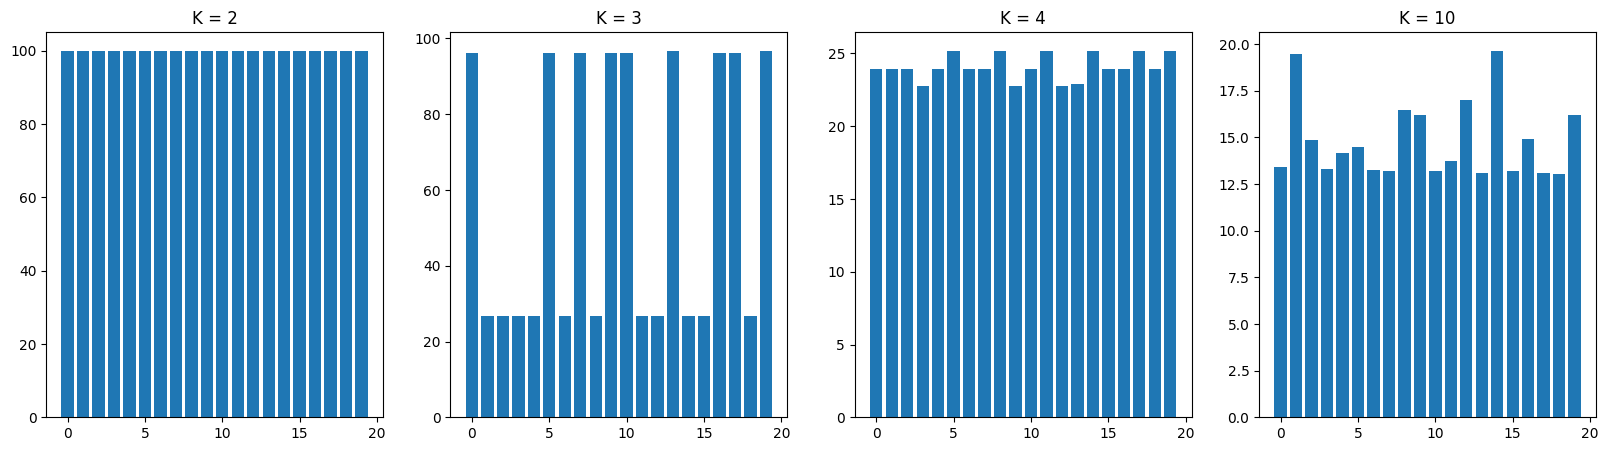

In [16]:
#Generation de mélange gaussien
n = 500
means = np.array([[0,0,0],[25,29,28],[15,15,15]])
covs = [np.array([[15, 1, 1], [1, 15, 1], [1,1, 15]]),np.array([[7, 1, 1], [1, 3, 1], [1, 1, 12]]),np.array([[4, 1, 1], [1, 5, 1], [1, 1, 6]])]
m,_ = gaussian_mixture(n,[1/3,1/3,1/3],means,covs)
N = 20

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
k=2
inerties = []
for i in range(N):
  km = sklearn.cluster.KMeans(n_clusters=k,init = 'random',n_init=1).fit(m)
  inerties.append(km.inertia_/n)
axs[0].bar(range(N), inerties)
axs[0].set_title("K = {}".format(k))
#axs[0].set_ylim(0,150)

k=3
inerties = []
for i in range(N):
  km = sklearn.cluster.KMeans(n_clusters=k,init = 'random',n_init=1).fit(m)
  inerties.append(km.inertia_/n)
print(inerties)
axs[1].bar(range(N), inerties)
axs[1].set_title("K = {}".format(k))
#axs[1].set_ylim(0,150)
k=4
inerties = []
for i in range(N):
  km = sklearn.cluster.KMeans(n_clusters=k,init = 'random',n_init=1).fit(m)
  inerties.append(km.inertia_/n)
axs[2].bar(range(N), inerties)
axs[2].set_title("K = {}".format(k))
#axs[2].set_ylim(0,150)
k=10
inerties = []
for i in range(N):
  km = sklearn.cluster.KMeans(n_clusters=k,init = 'random',n_init=1).fit(m)
  inerties.append(km.inertia_/n)
axs[3].bar(range(N), inerties)
axs[3].set_title("K = {}".format(k))
#axs[3].set_ylim(0,150)
plt.savefig('/content/variances_init.png')

plt.show()
#Cela confirme que l'algorithme ne trouve pas un minimum local mais global.


Centroids =  [-1.50818804  1.25705568  1.74885007]
Centroids =  [-1.50818804  1.25705568  1.74885007]


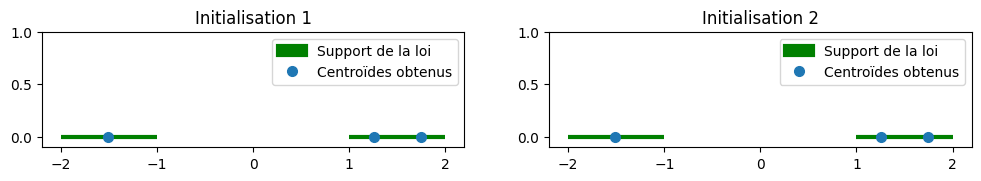

In [30]:
def u_uniform(n):
  """
  Sample (size n) of uniform distribution on [-2,-1]U[1,2]
  """
  random_gen=np.random.default_rng(seed)
  U = []
  for i in range(n):
    U.append(random_gen.uniform(low=-2, high=-1, size=None) if random_gen.random() < 0.5 else random_gen.uniform(low=1, high=2, size=None))
  return np.array(U)

U = u_uniform(1000)
U = U.reshape(-1,1)


fig, axs = plt.subplots(1, 2, figsize=(12, 1.5))
init_list = [np.array([[-1.7],[-1.5],[1.5]]),np.array([[-1.5],[1.5],[1.7]])]
cd_list_1 = []
cd_list_2 = []
for i, centers_init in enumerate(init_list):

    #km = sklearn.cluster.KMeans(n_clusters=3,init = centers_init,n_init = 1).fit(U)
    axs[i].fill_betweenx([0, 0], -2, -1, color='green',linewidth=3,label="Support de la loi")
    axs[i].fill_betweenx([0, 0], 1, 2, color='green',linewidth=3)

    #plt.plot(U, np.zeros_like(U), 'o', markersize=7)
    axs[i].plot(cd,np.zeros_like(cd), 'o', markersize=7,label="Centroïdes obtenus")
    axs[i].legend()
    # Ajouter un titre et des etiquettes d'axes
    axs[i].set_xticks(np.arange(-2, 3, 1))
    axs[i].set_ylim([-0.1, 1])
    axs[i].set_title('Initialisation {}'.format(i + 1))
    print("Centroids = ", np.concatenate(cd))

  
# Afficher le graphique
plt.savefig('/content/uniformes.png')
plt.show()



# Application au Mnist

## Visualisation

In [18]:
# Extraction de donnees mnist et division en donnees train et test
mnist = tf.keras.datasets.mnist
(x_train,y_train),(x_test,y_test) = mnist.load_data()
# 60000 datas pour train, 10000 pour test

11490434/11490434 [==============================] - 0s 0us/step


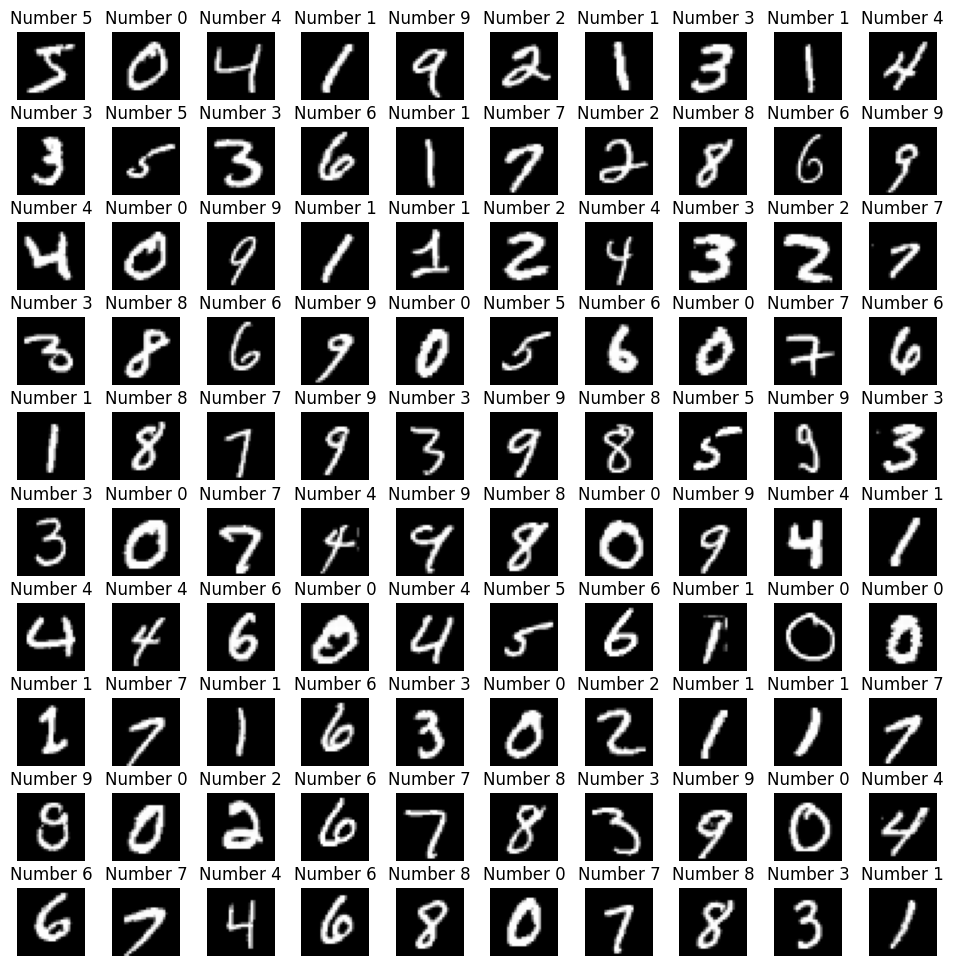

In [19]:
# Affichage de 100 donnees mnist
fig, axs = plt.subplots(10, 10, figsize = (12, 12))
plt.gray()

# Boucle sur les sous-graphes pour ajouter les images mnist
for i, ax in enumerate(axs.flat):
    ax.imshow(x_train[i])
    ax.axis('off')
    ax.set_title('Number {}'.format(y_train[i]))
  
plt.subplots_adjust(hspace=0.4)
plt.savefig('/content/mnist.png')
plt.show()

In [20]:
# On verifie que les valeurs vont de 0 à 255
print(x_train.min())
print(x_train.max())

0
255


In [21]:
# Normalisation des donnees
X = x_train.reshape(len(x_train),-1)/255
Xtest = x_test.reshape(len(x_test),-1)/255
Y = y_train
Ytest = y_test

In [22]:
# On verifie que les donnees sont bien standardises
print(X.min())
print(X.max())

0.0
1.0


## Entraînement

In [23]:
# Application de K-means pour K=10 avec sklearn
K = 10
n = len(x_train)
km = sklearn.cluster.KMeans(n_clusters=K,init='k-means++',verbose=2,random_state=2,n_init = 1).fit(X) #verbose = 2 pour afficher la variance


Initialization complete
Iteration 0, inertia 4006291.001307185.
Iteration 1, inertia 2478254.6282684174.
Iteration 2, inertia 2422025.241099925.
Iteration 3, inertia 2398894.2114901566.
Iteration 4, inertia 2388865.105411663.
Iteration 5, inertia 2383988.32687842.
Iteration 6, inertia 2380891.3318478363.
Iteration 7, inertia 2378646.156588889.
Iteration 8, inertia 2376985.6071334006.
Iteration 9, inertia 2375795.300337668.
Iteration 10, inertia 2374851.9212355614.
Iteration 11, inertia 2374160.7309019486.
Iteration 12, inertia 2373583.041939183.
Iteration 13, inertia 2373054.010845216.
Iteration 14, inertia 2372620.6565524573.
Iteration 15, inertia 2372258.9826771645.
Iteration 16, inertia 2371946.784533363.
Iteration 17, inertia 2371667.563752169.
Iteration 18, inertia 2371397.907098755.
Iteration 19, inertia 2371105.4617578303.
Iteration 20, inertia 2370808.033001596.
Iteration 21, inertia 2370536.104242325.
Iteration 22, inertia 2370282.790063707.
Iteration 23, inertia 2370081.31863

Regardons les résultats du K-Means sur les données d'entraînement. Nous pourrons ainsi vérifier l'adéquation d'un tel algorithme de classification sur ce type de données.

In [24]:
# Affichage des resultats metriques du K-means sur les donnees train
print("Resultats sur les donnees d'entrainement:")
print("Labels:", km.labels_)
print("Inertie: ",km.inertia_)
print("Variance: ", km.inertia_/n)
print("Score (oppose de l'inertie):", km.score(X))

Resultats sur les donnees d'entrainement:
Labels: [8 5 1 ... 2 9 9]
Inertie:  2369222.3625731682
Variance:  39.48703937621947
Score (oppose de l'inertie): -2369222.3625731682


Voici les centroids trouvés:

Centroids: 


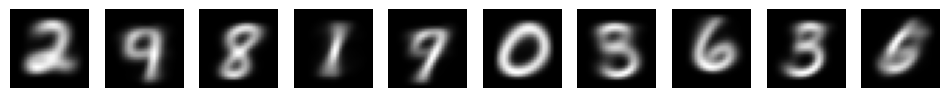

In [25]:
# Representation graphique des centroides trouves

clusterCenters = km.cluster_centers_  # Liste des centroides finaux

print("Centroids: ")
centroids = [np.reshape(a,(28,28)) for a in clusterCenters]
centroids *= 255
fig, axs = plt.subplots(1, 10, figsize = (12, 12))
plt.gray()

# Boucle sur les sous-graphes pour ajouter les images mnist
for i, ax in enumerate(axs.flat):
    ax.imshow(centroids[i])
    ax.axis('off')
    
# Affiche la figure
plt.savefig("/content/mnist_centroids.png")
plt.show()

In [29]:
def infer_cluster_labels(km, actual_labels):
    """
    Infere les etiquettes des clusters a partir des etiquettes reelles des points.

    Args:
        km (sklearn.cluster.KMeans): Objet KMeans contenant les resultats de l'algorithme.
        actual_labels (array-like): Tableau des etiquettes reelles des points.

    Returns:
        dict: Dictionnaire des etiquettes predites pour chaque cluster.

    """
    inferred_labels = {}

    # Boucle sur les clusters
    for i in range(km.n_clusters):

        # Trouve les indices des points du cluster
        labels = []
        index = np.where(km.labels_ == i)

        # Ajoute les vrais labels pour chaque point du cluster
        labels.append(actual_labels[index])

        # Determine le label le plus recurrent
        if len(labels[0]) == 1:
            counts = np.bincount(labels[0])
        else:
            counts = np.bincount(np.squeeze(labels))

        # Assigne le cluster a une valeur dans le dictionnaire inferred_labels
        if np.argmax(counts) in inferred_labels:
            # Ajoute le nouveau chiffre au tableau existant a cet emplacement
            inferred_labels[np.argmax(counts)].append(i)
        else:
            # Cree le nouveau tableau a cet emplacement
            inferred_labels[np.argmax(counts)] = [i]
        
    return inferred_labels

def infer_data_labels(X_labels, cluster_labels):
        """
        Infere les etiquettes de chaque tableau en fonction du cluster auquel il a ete attribue.

        Args:
            X_labels (array-like): Tableau des etiquettes reelles de chaque point.
            cluster_labels (dict): Dictionnaire des etiquettes predites pour chaque cluster.

        Returns:
            array-like: Tableau des etiquettes predites pour chaque point.

        """
        
        # tableau vide de taille len(X_labels)
        predicted_labels = np.zeros(len(X_labels)).astype(np.uint8)
        
        for i, cluster in enumerate(X_labels):
            for key, value in cluster_labels.items():
                if cluster in value:
                    predicted_labels[i] = key
                    
        return predicted_labels 


kmeansLabels = km.predict(X)
cluster_labels = infer_cluster_labels(km, y_train)
predicted_labels = infer_data_labels(kmeansLabels, cluster_labels)
print(predicted_labels[:20])
print(y_train[:20])
print("Predicted labels:", np.unique(predicted_labels))


[3 0 4 1 7 2 1 3 1 6 3 1 3 6 1 7 2 8 6 7]
[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9]
Predicted labels: [0 1 2 3 4 6 7 8]


On a comme résultats 9 labels, et le label 9 n'apparait pas dans la liste. Cela veut dire que même si notre algorithme trouve 10 clusters, il y a deux clusters qui sont associé à une même étiquette, donc à un même chiffre. L'algorithme du K-Means ne considère pas la forme du chiffre 9 comme une forme à part entière.

In [27]:
from sklearn.metrics import accuracy_score
print("Accuracy: ", accuracy_score(predicted_labels,y_train))

Accuracy:  0.5972166666666666


# Cellules de Voronoï

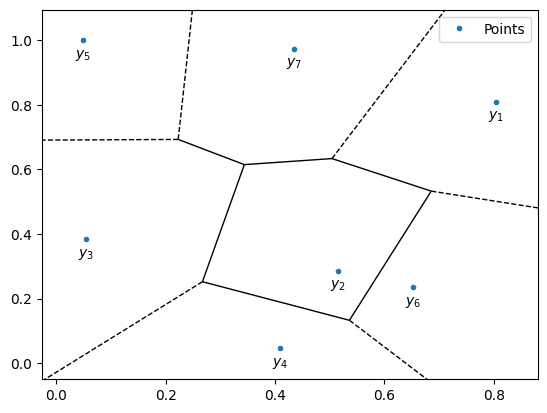

In [28]:

random_gen=np.random.default_rng(seed) 
points = random_gen.random((7, 2))
labels = ['$y_1$', '$y_2$', '$y_3$', '$y_4$', '$y_5$', '$y_6$', '$y_7$']

vor = Voronoi(points)
fig = voronoi_plot_2d(vor,show_vertices=False)
for i, label in enumerate(labels):
    plt.annotate(label, xy=points[i], xytext=(0, -5), textcoords='offset points', ha='center', va='top')
plt.legend(["Points"])
plt.savefig("/content/voronoi.png")
plt.show()